# <center>**Distance Measurement Process**<center>

#### **Goal:** obtain a distance error between the misclassified hand drawn spirals and the ideal model of an archimedean spiral.

Any functions / processes that require the use of tensorflow or keras need to be in this file. Other functions can be in a seperate python file. 

## **Process**
1. Preprocess the data for preparation to run through CNN model (need training, validation, and testing)
    - If model already trained, only the testing data is needed for evaluation
2. Evaluate the test data on the trained model 
    - Save and plot the results
3. Create an ideal archimedean spiral model 
    - This will be used for calculating distance, and eventually error, between the patient's hand drawn spiral and the mathematical model of the spiral
    - Plot the ideal spiral overlayed with the test spirals, along with their classifications
    - Need to get the spiral one-pixel-width thick

**Note: The following steps will ONLY be performed on spirals misclassified by the CNN**

4. Calculate the locations of the centers of the test spirals (using objectDetection.ipynb)
5.  Process each test spiral so that it is one-pixel-width thick
    - Consider erosion and skeletonization for this, and also contours
6. Use the calculated locations of the center to unravel the spiral
    - Will also need to unravel the ideal spiral
7. Can then calculate the distance between the two and get an error measurement

*Instead of unravelling first, can also attempt to calculate the distance between the two spirals overlayed, but I think this is a more complicated approach if unravelling can be done*

*Can also consider contours to get a single pixel width - refer to ECE5554 contour homework example*


In [1]:
# import libraries
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns # statistical data vis, used to plot the total count for each label
import os 
import wget
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn import utils # used to shuffle data


from keras.preprocessing.image import ImageDataGenerator # used for image augmentation
import tensorflow as tf
# used for building and training a new model
from keras import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout
import object_detection

# image conversion and processing libraries
import cv2
import PIL
from PIL import Image

In [2]:
# import functions from other python files
from code_files.imagePreprocessing import * 
from code_files.plottingFunctions import *
from code_files.archSpiral import *

In [3]:
# gpus = tf.config.experimental.list_physical_devices('GPU')
# tf.config.experimental.set_memory_growth(gpus[0], True)

os.environ['CUDA_VISIBLE_DEVICES'] = '-1' # disabling the GPU allows the model here to run

### Step 1: Preprocess the data (obtain training, validation, and testing data)

In [4]:
# import the images and create a dataframe containing the image path locations and their associated labels
dfTrain, dfVal, dfTest = importSetImages('datasets/spiral_data')

In [5]:
train_imgNames, trainLbl, val_imgNames, valLbl, test_imgNames, testLbl = dfTrain['images'], dfTrain['label'], dfVal['images'], dfVal['label'], dfTest['images'], dfTest['label']

In [6]:
# convert data into arrays and resize to size (128x128)
train, val, test = imgAug_preprocessing(train_imgNames, val_imgNames, test_imgNames)

**<center>NOTE: Only run the next code block if training a CNN model<center>**

In [7]:
# perform image augmentation if working on training a model (otherwise skip)
def imgAug(train_array, train_label, val_array, val_label, test_array, test_label):
    ## -------------------------------------------------------------------
    #       Artificially create more images for a bigger dataset
    ## -------------------------------------------------------------------
    # define functions to generate batches of data containing augmented images
    # use for training data only
    train_gen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=180,
        fill_mode='nearest',
        brightness_range=[.4,1.4],
        vertical_flip = True,
        horizontal_flip = True
    )

    # use for validation and testing data (OPTIONAL: can make this different than training)
    test_gen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=180,
        fill_mode='nearest',
        brightness_range=[.4,1.4],
        vertical_flip = True,
        horizontal_flip = True
    )

    ## define function to artificially add more training, validation, and testing images
    # takes as inputs the dataset array, dataset labels, and the number of additional augmented images per each original image
    def generateAdditionalData(dataset_array, dataset_label, numImgs):
        dataAug = []
        dataAugLabel = []

        # iterate through each image in the data_array and create more images with the features specified by ImageDataGenerator
        for (idx,Lbl) in enumerate(dataset_label):
            tempImg = np.expand_dims(dataset_array[idx], axis=0) # use for grayscale
            # tempImg = train_array[idx]                         # use for rgb
            aug = train_gen.flow(tempImg, batch_size=1, shuffle=True)
            for addImages in range(numImgs):
                augImg = next(aug)[0] #.astype('uint8')
                if np.size(augImg) == 128**2:
                    dataAug.append(augImg)
                    dataAugLabel.append(Lbl)

        return dataAug, dataAugLabel

    trainAug, trainAugLabel = generateAdditionalData(train_array, train_label, 90)
    valAug, valAugLabel     = generateAdditionalData(val_array, val_label, 90)
    # testAug, testAugLabel   = generateAdditionalData(test_array, test_label, 90)

    # covert label array to binary class matrix (healthy, PD)
    trainAugLabel = tf.keras.utils.to_categorical(np.array(trainAugLabel))
    valAugLabel = tf.keras.utils.to_categorical(np.array(valAugLabel))
    # testAugLabel = tf.keras.utils.to_categorical(np.array(testAugLabel))

    # shuffle data one last time
    trainAug, trainAugLabel = utils.shuffle(trainAug, trainAugLabel)
    valAug, valAugLabel = utils.shuffle(valAug, valAugLabel)
    # testAug, testAugLabel = utils.shuffle(testAug, testAugLabel)

    return trainAug, trainAugLabel, valAug, valAugLabel #, testAug, testAugLabel

trainAug, trainLblAug, valAug, valLblAug = imgAug(train, trainLbl, val, valLbl, test, testLbl)

**<center> CNN Model Code <center>**

In [8]:
# ---------------------------------------------------------------------------------------
#                             BUILD AND TRAIN A NEW MODEL
# ---------------------------------------------------------------------------------------
reg = tf.keras.regularizers.l2(0.001)               # include a regularizer to help prevent overfitting
opt = tf.keras.optimizers.Adam(learning_rate=1e-5)  # use the Adam optimizer and set an effective learning rate 

# build a model
model = Sequential([
    Conv2D(32, (3,3), padding='same', strides=(1,1), dilation_rate = 1, activation='relu', kernel_regularizer=reg, input_shape=(128,128,1)),
    MaxPool2D((3,3), strides=(1,1)),
    Conv2D(32, (3,3), padding='same', strides=(2,2), dilation_rate = 1, activation='relu', kernel_regularizer=reg),
    MaxPool2D((5,5), strides=(1,1)),
    Conv2D(64, (5,5), padding='same', strides=(1,1), dilation_rate = 2, activation='relu', kernel_regularizer=reg),
    MaxPool2D((5,5), strides=(2,2)),
    Conv2D(128, (7,7), padding='same', strides=(2,2), dilation_rate = 1, activation='relu', kernel_regularizer=reg),
    MaxPool2D((5,5), strides=(1,1)),
    Flatten(),

    ## include some fully connected layers
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(2,activation='softmax') # softmax used for classification, sigmoid better for regression
])

model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

## Train the model
trained_model = model.fit(np.array(trainAug), trainLblAug, batch_size=128, epochs=35, validation_data=(np.array(valAug), valLblAug))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 126, 126, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 63, 63, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 59, 59, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 59, 59, 64)        51264     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 28, 28, 64)       0

In [9]:
modelName ='20220915'

# save model
savenameh5 = modelName + '.h5'
savenametf = modelName + '.tf'
model.save(savenameh5)
model.save(savenametf)

INFO:tensorflow:Assets written to: 20220915.tf\assets


INFO:tensorflow:Assets written to: 20220915.tf\assets


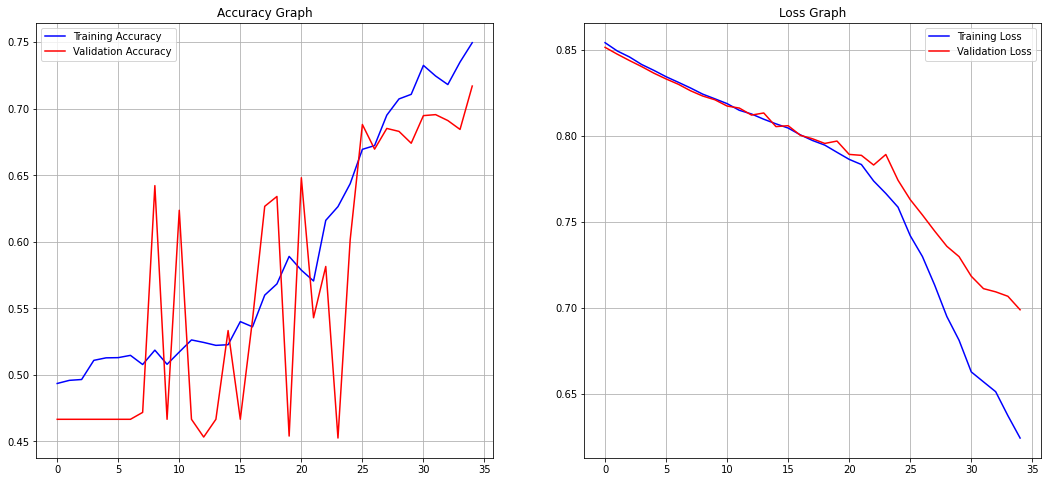

In [10]:
# -------------------------------------
# plot and save the results
# Accuracy and Validation Accuracy
accuracy1 = trained_model.history['accuracy']
val_acc1 = trained_model.history['val_accuracy']
epochs = range(len(accuracy1))

fig, ax = plt.subplots(1,2)
fig.set_size_inches(18,8)
ax[0].plot(epochs, accuracy1, 'b', label='Training Accuracy')
ax[0].plot(epochs, val_acc1, 'r', label='Validation Accuracy')
ax[0].title.set_text('Accuracy Graph')
ax[0].legend()
ax[0].grid()

# Loss and Validation Loss
loss1 = trained_model.history['loss']
val_loss1 = trained_model.history['val_loss']

ax[1].plot(epochs, loss1, 'b', label='Training Loss')
ax[1].plot(epochs, val_loss1, 'r', label='Validation Loss')
ax[1].title.set_text('Loss Graph')
ax[1].legend()
ax[1].grid()

savefigName = modelName + '20220915_accuracy_loss_graph.png'
fig.savefig(savefigName)

In [11]:
# ---------------------------------------------------------------------------------------
#                             LOAD PRE-EXISTING MODEL MODEL
# ---------------------------------------------------------------------------------------
def importModel(filename, testAug, testAugLabel):
    modelPath = 'savedModels/saved_h5_models/' + filename
    testModel = tf.keras.models.load_model(modelPath)

    loss, acc = testModel.evaluate(np.array(testAug), testAugLabel, verbose=2)
    print("Loss: ", loss, "| Accuracy: ", acc)

    return testModel

### Step 2: Evaluate the test data on the trained model 

In [12]:
# load existing model and evaluate the test data

# covert label array to binary class matrix (healthy, PD)
testLbl_categorical = tf.keras.utils.to_categorical(np.array(testLbl))
# test, testLbl = utils.shuffle(test, testLbl)
model = importModel('20220915.h5', test, testLbl_categorical)

1/1 - 0s - loss: 69.6215 - accuracy: 0.5625 - 374ms/epoch - 374ms/step
Loss:  69.6214599609375 | Accuracy:  0.5625


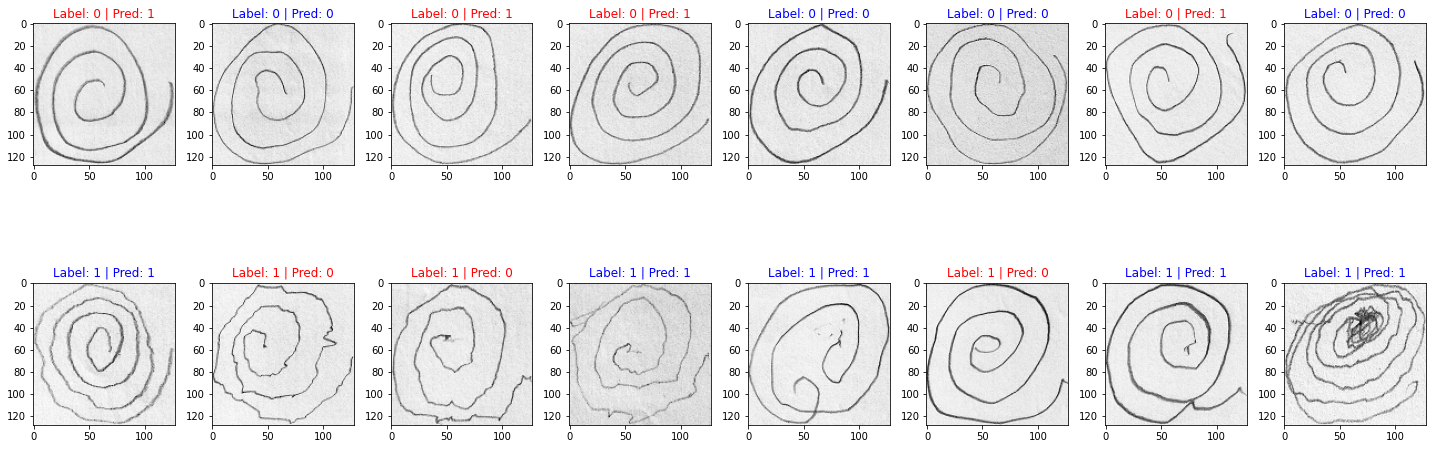

(7, 128, 128, 1)
[ 0  2  3  6  9 10 13]


In [13]:
# plot the results
misClass_test, misClass_idx = plotImages(model, test, testLbl)
print(np.shape(misClass_test))
print(misClass_idx)

In [9]:
# TO DO: save the misclassified images and the labels in seperate variables 
# (save off the variable to a folder for later use)
np.save('misclassified_image.npy', misClass_test)

# save the misClassified test images in their own folder
for i in range(len(misClass_idx)):
    im = Image.fromarray(np.squeeze(misClass_test[i]))
    savename = os.getcwd() + "\\incorrectImages\\testImg_" + str(i) + ".png"
    im.save(savename)

### Step 3: Create the ideal archimedean spiral model

(128, 128)


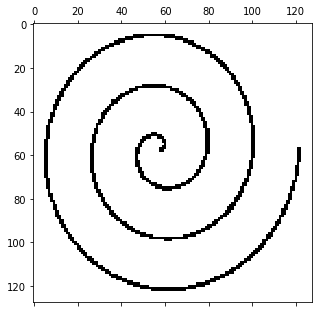

In [61]:
# create spiral
idealSpiral = generateIdealSpiral()
print(np.shape(idealSpiral))

# plot
plt.figure(figsize=(5,5))
plt.matshow(idealSpiral, cmap='gray', fignum=1)

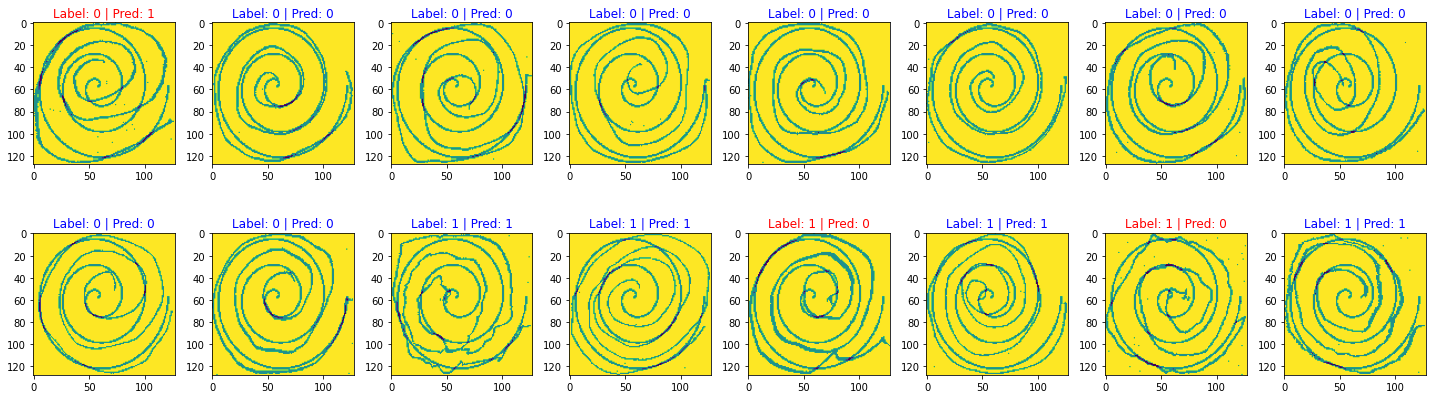

In [62]:
# plot the test spirals overlayed with ideal spiral
plotArchSpiralOverlay(test, testLbl_orig, idealSpiral, model)

### Step 4: Calculate the locations of the centers of the spirals

Process:
- Train the model on the train and validation set generated
- Evaluate the model
- Detect center location from an image (use test data)
- Find the coordinates of the center point

In [9]:
# Need to split up the train and validation data into appropriate folders in ...Tensorflow/workspace/images
import shutil

outerDir = 'C:/Users/rebec/Documents/git-repos/hand-tremor-detection/hand-drawn-spiral-classifier-100patients/'
tfDir = outerDir + 'Tensorflow/workspace/images/'

# check if folder exists: 
trainPath = os.path.join(tfDir, 'train')
testPath = os.path.join(tfDir, 'test')

os.mkdir(trainPath)
os.mkdir(testPath)

# if os.path.exists(trainPath): # if the path exists, delete and create a new one
#     os.remove(trainPath)
#     os.mkdir(trainPath)
#     os.remove(testPath)
#     os.mkdir(testPath)

# move train images to train folder
for i in range(len(train_imgNames)):
    foldername = train_imgNames.iat[i]
    filename_png = os.path.basename(outerDir + foldername)
    filename_xml = filename_png.replace(".png", ".xml")
    shutil.copy(tfDir + filename_png, tfDir + 'train/' + filename_png)
    shutil.copy(tfDir + filename_xml, tfDir + 'train/' + filename_xml)

# move val images to test folder
for i in range(len(val_imgNames)):
    foldername = val_imgNames.iat[i]
    filename_png = os.path.basename(outerDir + foldername)
    filename_xml = filename_png.replace(".png", ".xml")
    shutil.copy(tfDir + filename_png, tfDir + 'test/' + filename_png)
    shutil.copy(tfDir + filename_xml, tfDir + 'test/' + filename_xml)


In [16]:
%run objectDetection.ipynb

Successfully created the TFRecord file: Tensorflow\workspace\annotations\train.record
Successfully created the TFRecord file: Tensorflow\workspace\annotations\test.record
        1 file(s) copied.
python Tensorflow\models\research\object_detection\model_main_tf2.py --model_dir=Tensorflow\workspace\models\my_ssd_mobnet --pipeline_config_path=Tensorflow\workspace\models\my_ssd_mobnet\pipeline.config --num_train_steps=2000
python Tensorflow\models\research\object_detection\model_main_tf2.py --model_dir=Tensorflow\workspace\models\my_ssd_mobnet --pipeline_config_path=Tensorflow\workspace\models\my_ssd_mobnet\pipeline.config --checkpoint_dir=Tensorflow\workspace\models\my_ssd_mobnet


### Step 5: Obtain one-pixel-width thick spiral

In [ ]:
skelImgs = []

# skelImgs.append(skeletonize_imgs(idealSpiral))
for i in misClass_test:
    skelImgs.append(skeletonize_imgs(i))

plotSkelImgs(misClass_test, skelImgs)